# 🧠 Twitter Sentiment Analysis - EDA

Exploratory Data Analysis for the `tweet_eval` sentiment dataset using Hugging Face Datasets and Transformers.

Explore dataset structure, class balance, text length distributions, and prepare for tokenizer selection.

In [2]:
!pip install transformers huggingface_hub datasets -q

## 0. Getting Setup

For more infromation on *How to use* Hugging Face datasets package go through [`datasets` tutorial](https://huggingface.co/docs/datasets/en/loading)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

## 1. Load Dataset

In [4]:
dataset_name = "cardiffnlp/tweet_eval"
dataset_subset = "sentiment"

In [5]:
dataset = load_dataset(dataset_name, dataset_subset, download_mode="force_redownload")
dataset

README.md:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## 2 Explore Data

In [ ]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

In [7]:
df = pd.DataFrame(dataset['train'])
df.sample(5)

,text,label
18928,"""Extremely jealous of Owain's day off tomorrow...",0
3791,going to see Ant-man wednesday. hopefully its ...,1
9649,Laura Wright\u002c Gareth Malone\u002c Noah St...,1
31465,Serie A: Juve win 6th straight; Milan booed: R...,1
42005,Excited to hang out with Rae & Laurin tomorrow...,2


In [8]:
df['label'].unique()

array([2, 1, 0])

### 2.1 Label Marking

- `0` → Negative
- `1` → Neutral
- `2` → Positive

In [9]:
label_map = {
  0: "negative",
  1: "neutral",
  2: "positive"
}

df["label_text"] = df["label"].map(label_map)
df.head()

,text,label,label_text
0,"""QT @user In the original draft of the 7th boo...",2,positive
1,"""Ben Smith / Smith (concussion) remains out of...",1,neutral
2,Sorry bout the stream last night I crashed out...,1,neutral
3,Chase Headley's RBI double in the 8th inning o...,1,neutral
4,@user Alciato: Bee will invest 150 million in ...,2,positive


### 2.2 Class Distribution

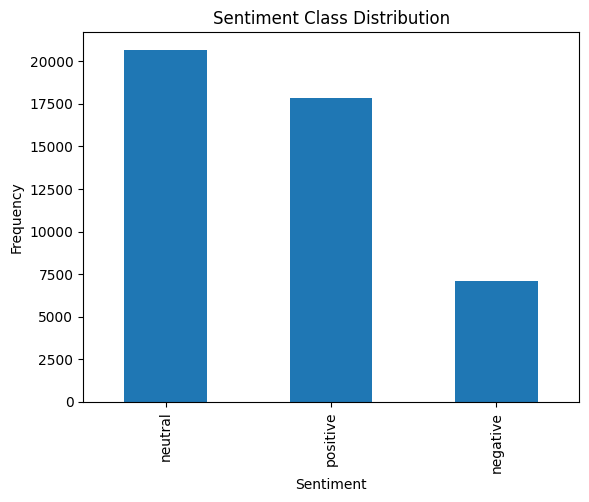

label_text
neutral     20673
positive    17849
negative     7093
Name: count, dtype: int64 

 label_text
neutral     0.453206
positive    0.391297
negative    0.155497
Name: count, dtype: float64


In [10]:
label_counts = df["label_text"].value_counts()
label_counts.plot(kind="bar", title="Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()

print(label_counts, "\n\n", label_counts / len(df))

### 2.3 Tweet Length Distribution

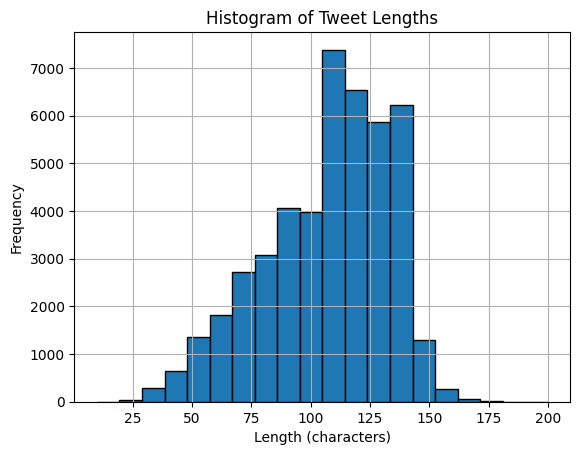

count    45615.000000
mean       106.932851
std         26.251517
min         10.000000
25%         89.000000
50%        113.000000
75%        128.000000
max        200.000000
Name: length, dtype: float64


In [11]:
df["length"] = df["text"].apply(len)

plt.hist(df["length"], bins=20, edgecolor="black")
plt.title("Histogram of Tweet Lengths")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(df["length"].describe())

### 2.4 Username Cleaning

In [12]:
def clean_usernames(text):
  return text.replace("@user", "").strip()

sample_text = df["text"].iloc[0]
print("Original:", sample_text)
print("Cleaned:", clean_usernames(sample_text))

Original: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
Cleaned: "QT  In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"


## 3. Tokenization & Preprocessing

### 3.1 Load Tokenizer

- We load the tokenizer that matches our pre-trained model (in this case, a RoBERTa-based model from CardiffNLP).

- Tokenizers convert raw text into numerical input (input_ids) that transformers understand. They also create attention masks.

- We use Hugging Face's AutoTokenizer which auto-selects the right tokenizer type for the given model name from the Hub.

In [13]:
from transformers import AutoTokenizer

MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
MAX_LENGTH = 256

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

### 3.2 Preprocessing Function

- We define a basic text cleaning function and apply it to remove @user mentions.

- The dataset uses @user to mask usernames. These tokens don't add value for sentiment and can confuse the model. Removing them improves clarity.

- A simple string replacement followed by .strip() to remove trailing spaces.

In [15]:
import re

def preprocess(text):
    text = re.sub(r"@user", "", text)
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"#(\w+)", r"\1", text)  # remove hashtags
    return text.replace("@user", "").strip()



df["clean_text"] = df["text"].apply(preprocess)
df[["text", "clean_text"]].head()

,text,clean_text
0,"""QT @user In the original draft of the 7th boo...","""QT In the original draft of the 7th book, Re..."
1,"""Ben Smith / Smith (concussion) remains out of...","""Ben Smith / Smith (concussion) remains out of..."
2,Sorry bout the stream last night I crashed out...,Sorry bout the stream last night I crashed out...
3,Chase Headley's RBI double in the 8th inning o...,Chase Headley's RBI double in the 8th inning o...
4,@user Alciato: Bee will invest 150 million in ...,Alciato: Bee will invest 150 million in Januar...


### 3.3 Tokenization

- Tokenize one tweet and preview the result.

- It helps us inspect how the text is converted to token IDs and whether the padding/truncation is behaving as expected.

- We tokenize with:
  - `truncation=True`: cuts longer texts
  - `padding="max_length"`: pads all sequences to 256 tokens
  - `return_tensors="pt"`: returns PyTorch tensors

In [16]:
encoding = tokenizer(
    df["clean_text"][0], truncation=True, padding="max_length", max_length=MAX_LENGTH
)
encoding

{'input_ids': [0, 113, 1864, 565, 1437, 96, 5, 1461, 2479, 9, 5, 262, 212, 1040, 6, 8022, 687, 26110, 179, 5601, 5, 9846, 9, 42210, 4, 9899, 44728, 1208, 31157, 687, 574, 658, 179, 113, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

### 3.4 Dataset → PyTorch Compatible Format

- We create a PyTorch-compatible dataset class so it can be used with DataLoader during training.

- Transformers require input_ids, attention_mask, and labels for training. PyTorch expects a Dataset that returns items this way.

- How
  - `__getitem__()` returns a dictionary of tokenized data and label

  - `.squeeze()` removes extra batch dimension (from `return_tensors="pt"`)

  - We wrap everything in a class for modularity and reusability

In [17]:
import torch
from torch.utils.data import Dataset


class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = preprocess(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long),
        }


# Create train dataset
train_dataset = TweetDataset(
    df["text"].tolist(), df["label"].tolist(), tokenizer, MAX_LENGTH
)
len(train_dataset), train_dataset[0]

(45615,
 {'input_ids': tensor([    0,   113,  1864,   565,  1437,    96,     5,  1461,  2479,     9,
              5,   262,   212,  1040,     6,  8022,   687, 26110,   179,  5601,
              5,  9846,     9, 42210,     4,  9899, 44728,  1208, 31157,   687,
            574,   658,   179,   113,     2,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,   

## 4. Define the Sentiment Classification Model

We'll be using a transformer-based model (like RoBERTa) with a classification head for sentiment prediction.

- ✅ What Are We Doing?
We're building a PyTorch model class that wraps a pre-trained transformer (like RoBERTa) and adds a classifier layer on top to predict:

  - Negative (0)

  - Neutral (1)

  - Positive (2)

- Why Are We Doing This?
Hugging Face models are powerful, but we need to:

  - Customize the classifier head

  - Freeze/unfreeze layers if needed

  - Support saving/loading easily

- We subclass torch.nn.Module and load AutoModelForSequenceClassification from Hugging Face.

In [18]:
device = (
  "cuda"
  if torch.cuda.is_available()
  else
  "mps"
  if torch.backends.mps.is_available()
  else
  "cpu"
)
device

'cuda'

In [19]:
import torch.nn as nn
from transformers import AutoModelForSequenceClassification


class SentimentClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(SentimentClassifier, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels
        )

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(
            input_ids=input_ids, attention_mask=attention_mask, labels=labels
        )


# Instantiate model
NUM_LABELS = 3
model = SentimentClassifier(model_name=MODEL_NAME, num_labels=NUM_LABELS).to(device)
model

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (model): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
               

### 4.1 Inspect Output from Forward Pass

In [25]:
sample = train_dataset[0]
output = model(
    input_ids=sample["input_ids"].unsqueeze(0).to(device),
    attention_mask=sample["attention_mask"].unsqueeze(0).to(device),
    labels=sample["label"].unsqueeze(0).to(device)
)
print("Loss:", output.loss.item())
print("Logits:", output.logits)
print(f"Prediction: ", label_map[torch.argmax(output.logits, dim=1).item()])

Loss: 0.04185459390282631
Logits: tensor([[-3.2711,  0.1074,  3.2935]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Prediction:  positive


## 5. Training the Model (PyTorch Loop)

- We're writing a training loop to:
  - Load data in batches

  - Run forward + backward passes

  - Optimize the model

  - Track loss and accuracy

- Why This Way?
  - Using a manual training loop gives:

  - Full control over training dynamics

  - Easier debugging

  - Compatibility with future custom models or experiments

- How Does It Work?
  - We use DataLoader for batching

  - Use AdamW optimizer (standard for Transformers)

  - Optionally use lr_scheduler and validation set

In [26]:
device

'cuda'

### 5.1 Evaluation Loop with Metrics

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

# Datasets
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)


### 5.2 Evaluation Function

In [28]:
def evaluate(model, val_loader):
    model.eval()
    preds_all = []
    labels_all = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    acc = accuracy_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all, average="weighted")
    return acc, f1


### 5.3 Training Loop

In [29]:
from torch.utils.data import DataLoader
from tqdm import tqdm

model.to(device)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training Loop
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward
        outputs = model(
            input_ids=input_ids, attention_mask=attention_mask, labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(
        f"Epoch {epoch + 1}: Loss = {total_loss:.4f}, Accuracy = {correct / total:.4f}"
    )

    val_acc, val_f1 = evaluate(model, val_loader)
    print(f"Validation Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")


100%|██████████| 2281/2281 [23:56<00:00,  1.59it/s]


Epoch 1: Loss = 1312.9981, Accuracy = 0.7457
Validation Accuracy: 0.7477, F1 Score: 0.7444


100%|██████████| 2281/2281 [23:56<00:00,  1.59it/s]


Epoch 2: Loss = 1018.8779, Accuracy = 0.8120
Validation Accuracy: 0.7513, F1 Score: 0.7514


100%|██████████| 2281/2281 [23:56<00:00,  1.59it/s]


Epoch 3: Loss = 697.5626, Accuracy = 0.8780
Validation Accuracy: 0.7444, F1 Score: 0.7451


## 6. Save Model

In [30]:
from pathlib import Path
import os

def save_model(model, output_dir="models/sentiment_roberta"):
    os.makedirs(output_dir, exist_ok=True)

    # Save model weights
    model.model.save_pretrained(output_dir)

    # Save tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.save_pretrained(output_dir)

    print(f"Model and tokenizer saved to: {output_dir}")

In [31]:
save_model(model)

Model and tokenizer saved to: models/sentiment_roberta
